# 02. Neural Netowrk classificaiton with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import sklearn

## 1. Make classification data and get it ready

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [5]:
# Mkae DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


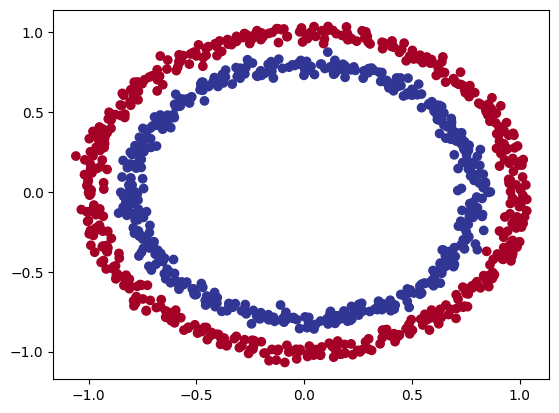

In [6]:
# Visualize the data

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: The data we're working with if often referred to as a toy data set, a dataset that is small enough to experiment on, but still sizeable enough to practice the fundamentals

### 1.1 Check input and output shapes

In [7]:
# A missmatch between input and output shapes can cause significant errors later on

X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [9]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [10]:
torch.__version__

'2.6.0+cu124'

In [11]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [13]:
type(X), type(y)

(torch.Tensor, torch.Tensor)

In [14]:
# Split data into random training and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 0.2 = 20% of data will be assigned to the test 80/20 split
                                                    random_state=42)

len(X_train), len(X_test)

(800, 200)

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 2. Building a model

Let's build a model to classify our blue and red dots.


To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [16]:
X_train.shape

torch.Size([800, 2])

In [17]:
# 1. Construct a model that subclasses nn.Module

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    # rule of thumb -> the more hidden features the more opportunities to learn patterns on the data
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

    # self.two_linear_layers == nn.Sequential(
    #     nn.Linear(in_features=2, out_features=5),
    #     nn.Linear(in_features=5, out_features=1)
    # )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_2(self.layer_1(x)) # x -> layer 1 -> layer 2 -> output

# 4. Instantiate and instance of the model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0



CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
next(model_0.parameters()).device

device(type='cpu')

In [19]:
 # Let's replicate the model aboive using nn.Sequential()

 model_0 = nn.Sequential(
     nn.Linear(in_features=2, out_features=5),
     nn.Linear(in_features=5, out_features=1)
 ).to(device)

 model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3293,  0.5630],
                      [ 0.6763, -0.4988],
                      [-0.5910, -0.3711],
                      [ 0.5468, -0.4137],
                      [-0.4280, -0.5696]])),
             ('0.bias', tensor([-0.3681,  0.5719, -0.0693, -0.0438,  0.6945])),
             ('1.weight',
              tensor([[-0.0728,  0.3533, -0.0738,  0.2895,  0.0152]])),
             ('1.bias', tensor([0.0782]))])

In [21]:
# Make some predictions with the model
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
  print(f"Lenght of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
  print(f"\nFirst 10 predictions: \n{untrained_preds[:10]}")
  print(f"\nFirst 10 labels: \n{y_test[:10]}")

Lenght of predictions: 200, Shape: torch.Size([200, 1])

First 10 predictions: 
tensor([[-0.0792],
        [ 0.0115],
        [ 0.0881],
        [-0.1283],
        [ 0.7312],
        [ 0.7816],
        [ 0.5274],
        [ 0.7094],
        [ 0.0607],
        [ 0.0247]])

First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use? -> problem specific

For example for regression you might want MAE or MSE (mean absolute error or mean squared error)

For classification you might want binary cross entropy or categorical cross entropy.

For optimizers, two of the most common and useful are SGD and Adam.

In [22]:
loss_fn = nn.BCEWithLogitsLoss() # WithLogitsLoss = sigmoid activation function built it (Hidden layer = ReLU, output layer = Sigmoid)

optimizer = torch.optim.SGD(model_0.parameters(),
                            lr = 0.1)

In [23]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calulates whether two tensors are equal
  acc = (correct/len(y_pred))*100
  return acc

In [24]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0792],
        [ 0.0115],
        [ 0.0881],
        [-0.1283],
        [ 0.7312]], grad_fn=<SliceBackward0>)

In [25]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4802],
        [0.5029],
        [0.5220],
        [0.4680],
        [0.6751]], grad_fn=<SigmoidBackward0>)

In [26]:
# Find the predicted labels (round the prediction probabilities)

y_preds = torch.round(y_pred_probs)

# Putting it all together

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 1., 1., 0., 1.], grad_fn=<SqueezeBackward0>)

In [27]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [28]:
torch.manual_seed(42)
epochs = 100

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

#___________________________________
#
# 1. Set training mode
# 2. Peform forward pass
# 3. Calculate the loss
# 4. Set gradients to zero
# 5. Perform the backward pass
# 6. Perform the step
#
#___________________________________


# After performing a training loop, set to eval for testing


for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze() # squeeze to remove the extra 1 dimension
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  loss = loss_fn(y_logits,
                 y_train)

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()


  # test mode
  model_0.eval()
  with torch.inference_mode():

    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_accuracy = accuracy_fn(y_true=y_test, y_pred=test_pred)


  # print out what is happening every 10 epochs
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | loss: {loss} | accuracy: {acc} | test_loss: {test_loss} | test_accuracy: {test_accuracy}")



Epoch: 0 | loss: 0.7218883633613586 | accuracy: 51.74999999999999 | test_loss: 0.7140552997589111 | test_accuracy: 55.00000000000001
Epoch: 10 | loss: 0.7060554623603821 | accuracy: 50.125 | test_loss: 0.7030417919158936 | test_accuracy: 55.50000000000001
Epoch: 20 | loss: 0.700131356716156 | accuracy: 50.5 | test_loss: 0.699164867401123 | test_accuracy: 52.5
Epoch: 30 | loss: 0.6975222826004028 | accuracy: 49.625 | test_loss: 0.6975044012069702 | test_accuracy: 51.5
Epoch: 40 | loss: 0.6961454749107361 | accuracy: 49.625 | test_loss: 0.6965988278388977 | test_accuracy: 51.5
Epoch: 50 | loss: 0.6952986121177673 | accuracy: 49.625 | test_loss: 0.6959992051124573 | test_accuracy: 52.0
Epoch: 60 | loss: 0.6947216987609863 | accuracy: 49.5 | test_loss: 0.6955594420433044 | test_accuracy: 50.0
Epoch: 70 | loss: 0.6943060159683228 | accuracy: 49.625 | test_loss: 0.6952241659164429 | test_accuracy: 50.0
Epoch: 80 | loss: 0.693997323513031 | accuracy: 49.625 | test_loss: 0.694966733455658 | te

Hey, the model is very shite, to be the nicest, it is randomly predicting, even after 100 epochs, something needs to be done here.

## 4. Make predictions and evaluate the model

We can attempt to plot our prediction to see what's going on.

For that purpose we can use some helper functions from the repo, which contains functions to plot the decision boundaries found by our model.

In [29]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


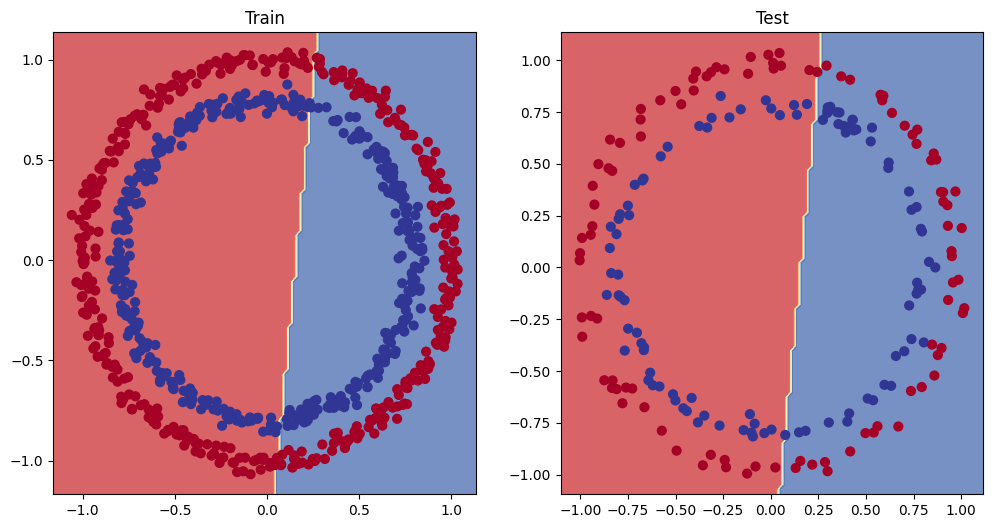

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

As we can see from these two plots, out model obtains an accuracy of around 50% as it is trying to "split" the data using a straight line. Our model is currently **underfitting**, meaning it is not currently learning predictive patters from the data.

## 5. Improving a model (from a model prespective)

A few ways to do so:

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - similar benefits as above
* Fitting for longer - Increasing the epochs hoping the model gets more chance to find a pattern
* Changing the activation functions - Some data can't be fit with only straight lines, using non-linear activation functions can help with that.
* Change the learning rate
* Change the loss function
* Use transfer learning - Taking a pretrained model from a problem domain similar to our problem and adjusting it to our problem.

Let's first try to add an extra layer to our model, fit for longer and increase the number of hidden units from `5` to `10`.

In [31]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [32]:
next(model_1.parameters()).device

device(type='cpu')

In [33]:
# Recreating our optimzer and loss function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.1)

In [34]:
# Training loop once again

torch.manual_seed(42)

epochs = 1000

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  accuracy = accuracy_fn(y_true=y_train, y_pred=y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()
  with torch.inference_mode():

    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_accuracy = accuracy_fn(y_true=y_test, y_pred=test_preds)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | loss: {loss} | accuracy: {acc} | test_loss: {test_loss} | test_accuracy: {test_accuracy}")

Epoch: 0 | loss: 0.6939550638198853 | accuracy: 49.0 | test_loss: 0.6926146149635315 | test_accuracy: 51.0
Epoch: 100 | loss: 0.6930477619171143 | accuracy: 49.0 | test_loss: 0.6937903761863708 | test_accuracy: 48.0
Epoch: 200 | loss: 0.692986011505127 | accuracy: 49.0 | test_loss: 0.6943727731704712 | test_accuracy: 46.0
Epoch: 300 | loss: 0.6929805278778076 | accuracy: 49.0 | test_loss: 0.6945767998695374 | test_accuracy: 45.0
Epoch: 400 | loss: 0.6929798722267151 | accuracy: 49.0 | test_loss: 0.6946452260017395 | test_accuracy: 46.0
Epoch: 500 | loss: 0.6929798722267151 | accuracy: 49.0 | test_loss: 0.6946679949760437 | test_accuracy: 46.0
Epoch: 600 | loss: 0.6929798722267151 | accuracy: 49.0 | test_loss: 0.6946756839752197 | test_accuracy: 46.0
Epoch: 700 | loss: 0.6929798722267151 | accuracy: 49.0 | test_loss: 0.6946782469749451 | test_accuracy: 46.0
Epoch: 800 | loss: 0.6929798722267151 | accuracy: 49.0 | test_loss: 0.6946792006492615 | test_accuracy: 46.0
Epoch: 900 | loss: 0.6

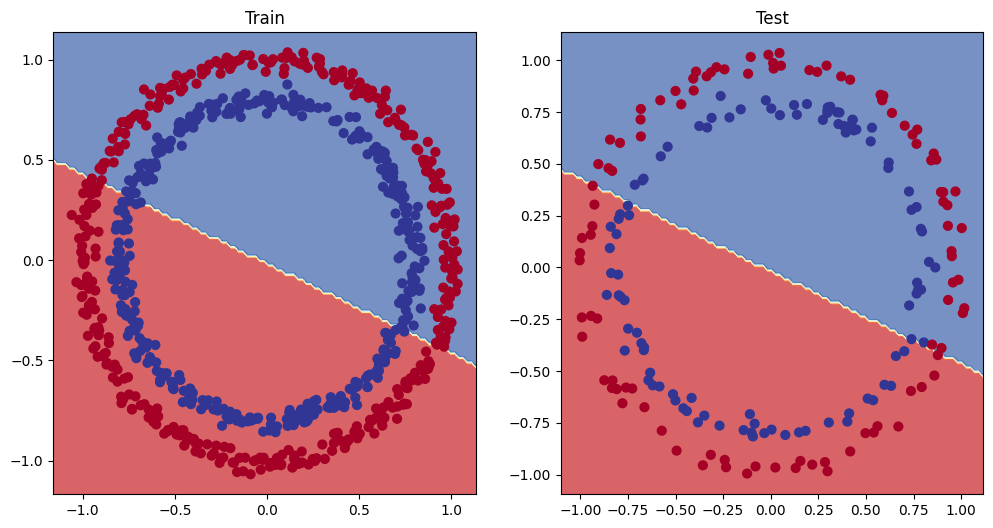

In [35]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1. Preparing data to see if our model can model a straight line

Let's create some linear data to see if our model's able to model it and we're not just using a model that can't learn anything.

In [36]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = (X_regression * weight + bias) # simple linear regression formula

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [37]:
training_split = int(0.8 * len(X_regression))

X_train_regression, y_train_regression = X_regression[:training_split], y_regression[:training_split]
X_test_regression, y_test_regression = X_regression[training_split:], y_regression[training_split:]

print(len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression))

80 80 20 20


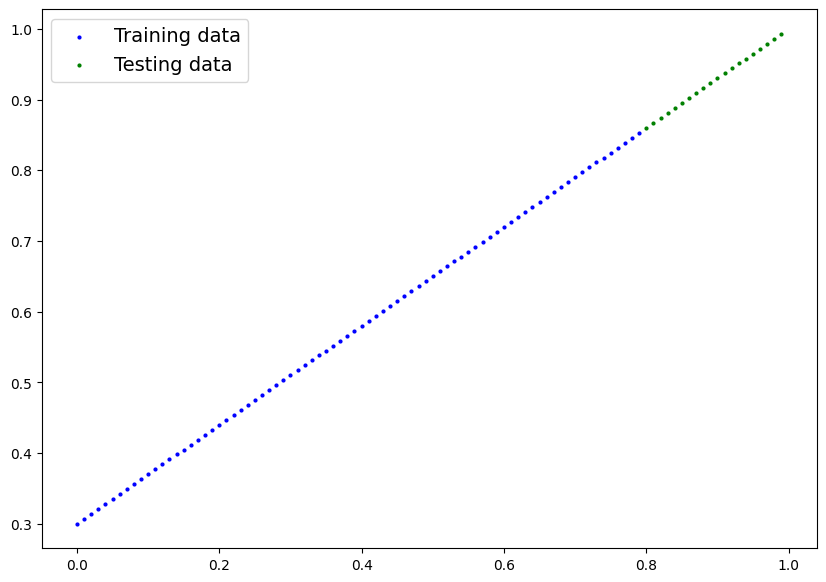

In [38]:
# This time we can use plot predictions to see our data looks

plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2. Adjusting `model_1` to fit a straight line

Now that we have data, we can re-create `model_1` but with a loss function suited for our regression data.

In [39]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [40]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [41]:
# We can reuse the exact same training loop to train our model this time

torch.manual_seed(42)

epochs = 1000

X_train_regression, X_test_regression, y_train_regression, y_test_regression = X_train_regression.to(device), X_test_regression.to(device), y_train_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  model_2.train()

  y_logits = model_2(X_train_regression)

  loss = loss_fn(y_logits, y_train_regression)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_2.eval()
  with torch.inference_mode():

    test_logits = model_2(X_test_regression)

    test_loss = loss_fn(test_logits, y_test_regression)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | loss: {loss} | test_loss: {test_loss}")

Epoch: 0 | loss: 0.7598584890365601 | test_loss: 0.9110288619995117
Epoch: 100 | loss: 0.02857953868806362 | test_loss: 0.0008127152686938643
Epoch: 200 | loss: 0.025325417518615723 | test_loss: 0.002092066453769803
Epoch: 300 | loss: 0.021374788135290146 | test_loss: 0.0030509470961987972
Epoch: 400 | loss: 0.019644945859909058 | test_loss: 0.003407782409340143
Epoch: 500 | loss: 0.019402235746383667 | test_loss: 0.0038725673221051693
Epoch: 600 | loss: 0.019032442942261696 | test_loss: 0.003789058420807123
Epoch: 700 | loss: 0.01878291741013527 | test_loss: 0.003813347313553095
Epoch: 800 | loss: 0.01839740015566349 | test_loss: 0.0032872825395315886
Epoch: 900 | loss: 0.017980266362428665 | test_loss: 0.00360372057184577


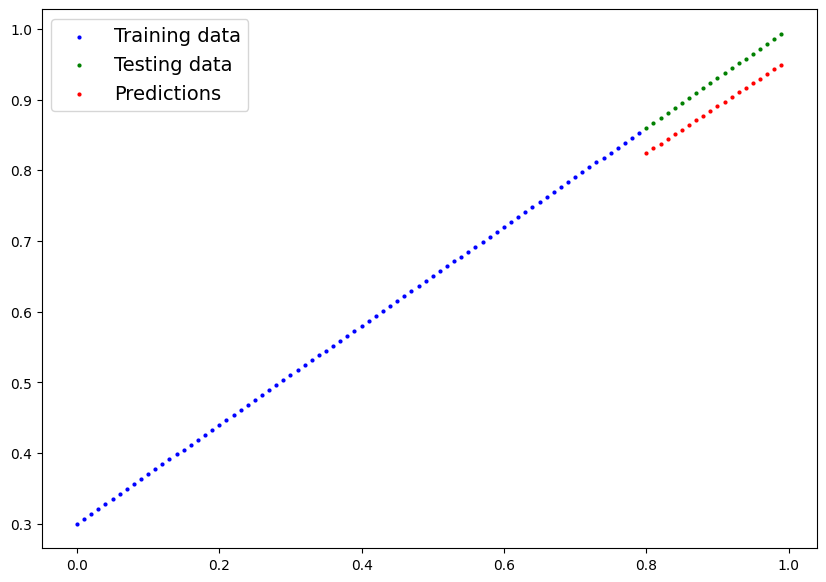

In [42]:
# Now let's plot the data to visualize

model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test_regression)


# As always for us to be able to plot using matplotlib (and hence numpy as well), we need to transfer our data to the CPU, this time instead, we can simply use `.cpu()`
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## 6. The missing piece: non-linearity

We've seen our model can draw a straight (linear) line, thanks to it's linear layers.

But, to give it the capacity to draw non-linear lines, we need to change something.


### 6.1 Recreating non-linear data (red and blue circles)

First let's recreated the data to start off fresh.

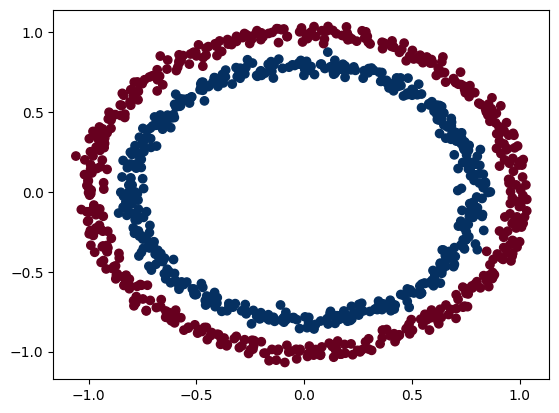

In [43]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=n_samples, random_state=42, noise=0.03)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [44]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2. Building a model with non-linearity

First we will introduce **non-lineara activation functions**.

One of the most common and best performing is `ReLU`.

In [45]:
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=10)
    self.layer_4 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()


  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))


model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=10, bias=True)
  (layer_4): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [46]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr = 0.1)

### 6.3 Training a model with non-linearity

Business as usual

In [47]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

torch.manual_seed(42)
epochs = 10000

model_3 = model_3.to(device)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):

  model_3.train()

  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  accuracy = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()


  model_3.eval()
  with torch.inference_mode():

    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_accuracy = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 1000 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {accuracy:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_accuracy:.2f}%")

  # scheduler.step(loss)

Epoch: 0 | Loss: 0.69815, Accuracy: 50.00% | Test Loss: 0.69751, Test Accuracy: 50.00%
Epoch: 1000 | Loss: 0.67715, Accuracy: 56.00% | Test Loss: 0.67315, Test Accuracy: 56.50%
Epoch: 2000 | Loss: 0.03970, Accuracy: 100.00% | Test Loss: 0.07811, Test Accuracy: 98.00%
Epoch: 3000 | Loss: 0.00651, Accuracy: 100.00% | Test Loss: 0.03607, Test Accuracy: 98.00%
Epoch: 4000 | Loss: 0.00335, Accuracy: 100.00% | Test Loss: 0.03374, Test Accuracy: 98.50%
Epoch: 5000 | Loss: 0.00219, Accuracy: 100.00% | Test Loss: 0.03352, Test Accuracy: 98.50%
Epoch: 6000 | Loss: 0.00161, Accuracy: 100.00% | Test Loss: 0.03373, Test Accuracy: 98.50%
Epoch: 7000 | Loss: 0.00125, Accuracy: 100.00% | Test Loss: 0.03588, Test Accuracy: 98.50%
Epoch: 8000 | Loss: 0.00102, Accuracy: 100.00% | Test Loss: 0.03641, Test Accuracy: 98.50%
Epoch: 9000 | Loss: 0.00085, Accuracy: 100.00% | Test Loss: 0.03683, Test Accuracy: 98.50%


### 6.4 Evaluating a model trained with non-linear activation functions

Let's see how it does

In [48]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X.to(device)))).squeeze()

y_preds[:10], y[:10]

(tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

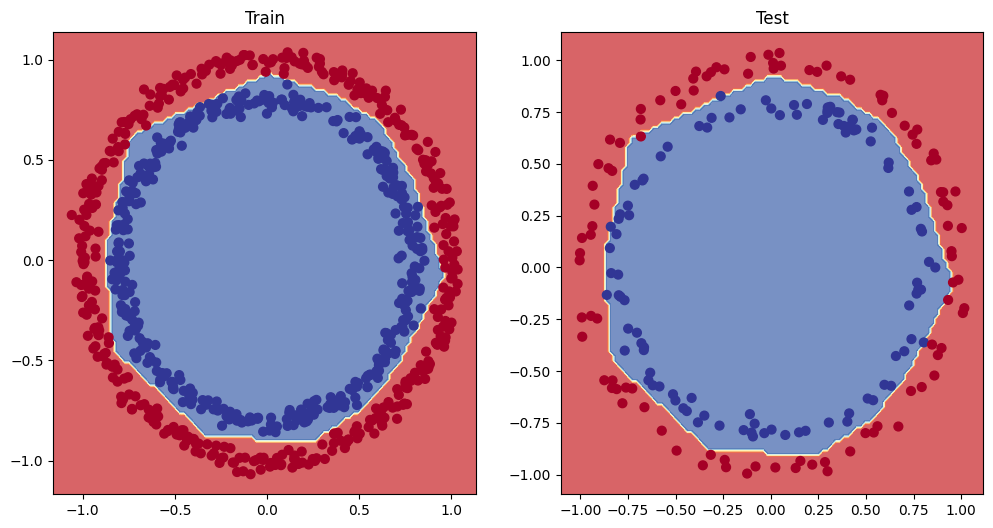

In [49]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## 7. Replicating non-linear activation functions

We saw how add non-linear function to our model can help it model non-linear data.

> Much of the data we will encounter is non-linear, hence the importance of being able to model non-linear patterns.

Let's replicate some of these non-linear activation functions.

In [50]:
# Create a toy tensor (similar to the data going into our models)
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

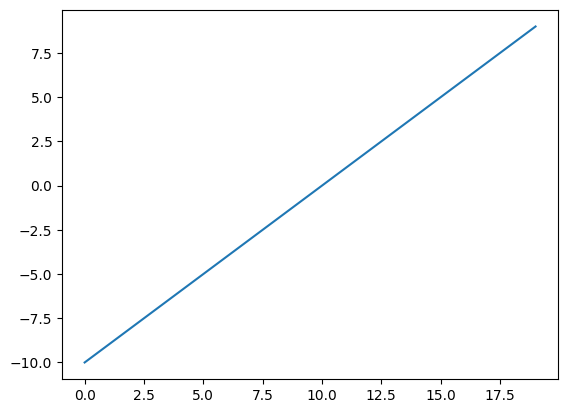

In [51]:
# visualize the toy tensor
plt.plot(A)

Now let's see how the ReLU activation function influences it, and instead of using PyTorch's included ReLU, we will create our own.

> The ReLU function turns all negatives to $0$ and leaves the positive values as they are.

$$
\text{ReLU}(x) = \begin{cases} x & x \ge 0 \\ 0 & x < 0\end{cases}
$$

In [52]:
def relu(x):
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

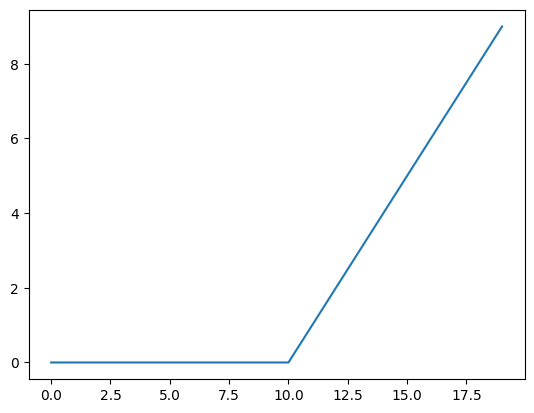

In [53]:
# Now let's plot again
plt.plot(relu(A))

Now let's try it with the sigmoid function. The sigmoid function is defined as:

$$
out_i = \frac{1}{1+e^{-input_i}}
$$

Or using $x$ as input:

$$
S(x) = \frac{1}{1+e^{-x_i}}
$$

Let's replicate it in code

In [54]:
# Create a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))


sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

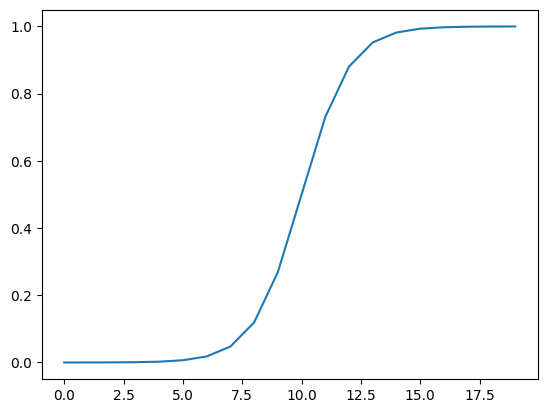

In [55]:
plt.plot(sigmoid(A))

## 8. Putting things together by building a multi-class PyTorch model

**Multi-class classification** problems deal with classifying something from a list of *more than* two options.


### 8.1 Creating multi-class classification data

To create our multi-class data, we can start with using Scikit-Learn's `make_blobs()` method.

This method will create however many classes (using the `center` parameter) we want.

Let's do the following:
1. Create some multi-class data with `make_blobs()`
2. Turn the data into sensors (the default of `make_blobs()` is to use NumPy arrays)
3. Split the data into training and tests sets using the `train_test_split()` function.
4. Visualize the data.

tensor([[-12.4557,  -1.8893],
        [  4.2692,  -9.6953],
        [ -2.2727,   1.9602],
        [  3.0626,  -8.6232],
        [ -3.0657,   4.5843]]) tensor([3, 0, 1, 0, 1])


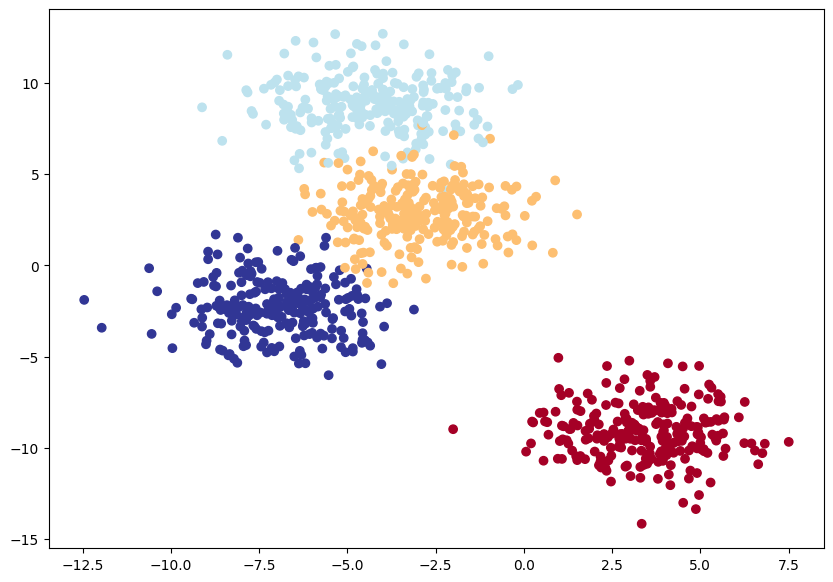

In [131]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 51

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 8.2. Building a multi-class classification model in PyTorch

We will build a model similar to the `model_3`, but capable of handling multi-class data.

To do so, we'll create a model that takes in three hyperparameters:
- `input_features` - the number of `X` features coming into the model
- `output_features` - the ideal number of output features we'd like (this will be equivalent to `NUM_CLASSES` or the number of classes in our multi-class classification problem).
- `hidden_units` - the number of hidden neurons we'd like each hidden layer to use.

In [132]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [145]:
from torch import nn

# Build model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initalizes all required hyperparameters for a multi-class classification model.

    Args:
      input_features(int)
      output_features(int)
      hidden_units(int)

    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        # nn.ReLU(), # does our model need non linear features for this classfication? TODO LATER
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(
    input_features=NUM_FEATURES,
    output_features=NUM_CLASSES,
    hidden_units=8
).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Creating a loss function and optimizer for multi-class PyTorch model

Since we are working on a multi-class classfiiciation problem, it is finally time to use the `nn.CrossEntropyLoss()` method as our loss function.

And we'll stick to Stochastic Gradient Descent (SGD) for our optimizer choice.

In [146]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr = 0.1)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

Let's start doing a simple forward pass to see what's going on

In [147]:
model_4(X_train.to(device))[:5]

tensor([[ 0.0528, -0.1734,  0.0543, -0.0126],
        [ 0.0766, -0.1373,  0.0857, -0.0210],
        [ 0.4422, -0.2317,  0.4752,  0.3401],
        [ 0.4384, -0.2177,  0.4729,  0.3265],
        [ 0.1751, -0.3499,  0.1636,  0.2173]], grad_fn=<SliceBackward0>)

In [148]:
# It looks like we are getting one value per feature, check shape
model_4(X_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

Now this is great, we are getting our logits out of our model, but we want to extract the actual decision output of our model to classify the input.

It's time to get out the **softmax activation functinon**.

> The softmax function calculates the probability of each prediction class beign the actual predicted class compared to all other possible classes.

In [149]:
# Make prediction logits with model
y_logits = model_4(X_blob_train.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 2.7656e+00, -1.1302e-03,  3.0699e+00,  2.0096e+00],
        [-6.2735e-01,  9.4723e-01, -5.3390e-01, -1.3964e+00],
        [ 5.5617e-01, -1.3314e+00,  4.4211e-01,  1.2589e+00],
        [-5.0412e-01,  7.0352e-01, -4.3321e-01, -1.1150e+00],
        [ 5.4248e-01, -8.4804e-01,  4.9677e-01,  8.8397e-01]],
       grad_fn=<SliceBackward0>)
tensor([[0.3462, 0.0218, 0.4694, 0.1626],
        [0.1353, 0.6534, 0.1486, 0.0627],
        [0.2461, 0.0373, 0.2196, 0.4970],
        [0.1677, 0.5612, 0.1801, 0.0911],
        [0.2769, 0.0689, 0.2645, 0.3896]], grad_fn=<SliceBackward0>)


In [150]:
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [151]:
# We can simply make our choise based on the most likely class
# Therefore we can check using `torch.argmax()` and output the index found
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3462, 0.0218, 0.4694, 0.1626], grad_fn=<SelectBackward0>)
tensor(2)


### 8.5 Creating a training and testing loop for a multi-class PyTorch model

In [152]:
y_blob_train.dtype, y_logits.dtype

(torch.int64, torch.float32)

In [153]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

torch.manual_seed(42)

epochs = 1000


# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)


for epoch in range(epochs):

  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels


  # 2. Calculate loss and accuracy
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()


  model_4.eval()
  with torch.inference_mode():

    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

  if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

  scheduler.step(loss)

Epoch: 0 | Loss: 1.91185, Acc: 0.00% | Test Loss: 0.92821, Test Acc: 53.00%
Epoch: 100 | Loss: 0.21040, Acc: 92.00% | Test Loss: 0.22847, Test Acc: 90.00%
Epoch: 200 | Loss: 0.15259, Acc: 95.00% | Test Loss: 0.16746, Test Acc: 94.50%
Epoch: 300 | Loss: 0.10875, Acc: 97.12% | Test Loss: 0.11998, Test Acc: 97.00%
Epoch: 400 | Loss: 0.08210, Acc: 97.75% | Test Loss: 0.09115, Test Acc: 98.00%
Epoch: 500 | Loss: 0.06756, Acc: 97.88% | Test Loss: 0.07572, Test Acc: 98.00%
Epoch: 600 | Loss: 0.05941, Acc: 97.88% | Test Loss: 0.06734, Test Acc: 98.00%
Epoch: 700 | Loss: 0.05453, Acc: 98.00% | Test Loss: 0.06250, Test Acc: 98.00%
Epoch: 800 | Loss: 0.05140, Acc: 97.88% | Test Loss: 0.05952, Test Acc: 98.00%
Epoch: 900 | Loss: 0.04930, Acc: 97.88% | Test Loss: 0.05759, Test Acc: 98.00%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [154]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-20.0927,  10.6234,  16.4701, -11.5552],
        [-21.8868,  10.2697,  18.0800,  -3.8433],
        [-18.5665,  10.1939,  14.8654,  -7.7363],
        [-17.4689,   9.9861,  13.7439,  -6.4256],
        [-18.4512,   9.8527,  14.6447,  -3.0583],
        [ 16.9747,   5.1829, -20.8970,  10.2857],
        [-15.7672,   9.7809,  12.0427,  -6.0556],
        [  5.4770,   5.9140,  -9.6143,  17.1045],
        [ -5.1170,   8.0914,   1.2657,   2.0149],
        [  5.6146,   5.8478,  -9.7678,  17.8392]])

In [155]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn predictions probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels:      {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([2, 2, 2, 2, 2, 0, 2, 3, 1, 3])
Labels:      tensor([2, 2, 2, 2, 2, 0, 2, 3, 1, 3])
Test accuracy: 98.0%


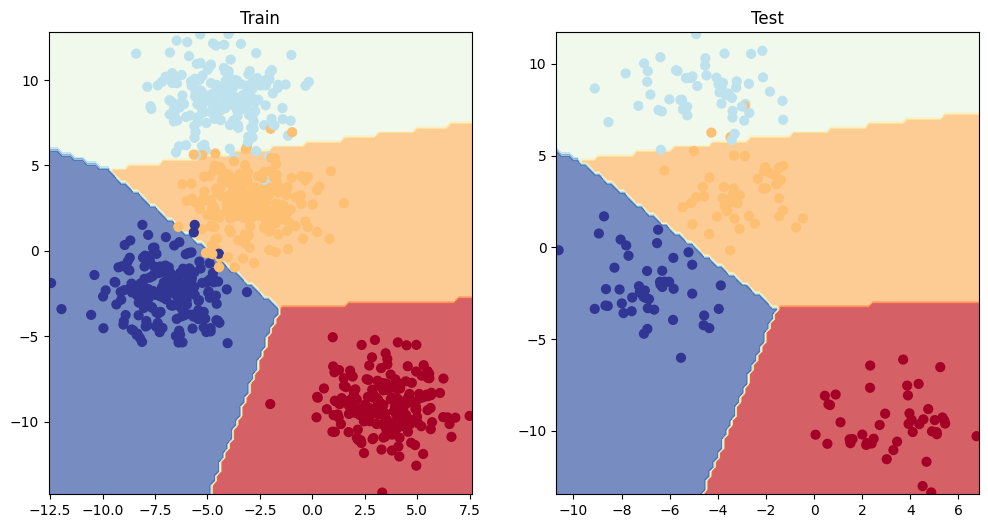

In [156]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. More classification evaluation metrics

There are a lot of ways to evaluate a classification model else than accuracy, here are some common ones:

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`torchmetrics.Accuracy()`](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html#id3) or [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`torchmetrics.Precision()`](https://torchmetrics.readthedocs.io/en/stable/classification/precision.html#id4) or [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`torchmetrics.Recall()`](https://torchmetrics.readthedocs.io/en/stable/classification/recall.html#id5) or [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`torchmetrics.F1Score()`](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html#f1score) or [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html#confusionmatrix) or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |
